In [1]:
import numpy as np

import matplotlib.pyplot as plt

from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

from scipy.signal.windows import dpss

from tqdm import tqdm

# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[25]
print(Lambda)



chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)

0.0035564803062231283
13


In [2]:
denser_Lambda = np.logspace(-4, -1, 50)[26]
print(denser_Lambda)

0.003906939937054617


[]

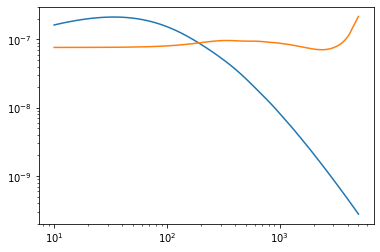

In [3]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [4]:
chis_restricted = chis_resample[np.where((chis_resample >= chimin) & (chis_resample <= chimax))]

In [5]:
D = np.diag(chis_restricted)

d = D @ IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', d.T, x)

# D = np.diag(chis_restricted)
# d = D @ IHi_kappa_windowed.T
# x = np.linalg.solve(D @ eHIeHI @ D, d)
# res1 = np.einsum('ij, ji->i', d.T, x)

In [6]:
f_d = interp1d(x = chis_restricted, y = d, axis = 0)

In [7]:
#get the denser sampling
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, denser_Lambda,14)
denser_eIeI = np.load(oup_fname + 'eIeI.npy')
denser_eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
denser_eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
denser_eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
denser_eHIeHI = denser_eIeI + denser_eLOeLO - denser_eIeLO - denser_eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, denser_Lambda,14)
denser_IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]

denser_chis_resample = np.linspace(10, chimax_sample, 2**14)
denser_window = np.where((denser_chis_resample > chimin) & (denser_chis_resample < chimax))[0]
denser_chis_restricted = denser_chis_resample[np.where((denser_chis_resample >= chimin) & (denser_chis_resample <= chimax))]
denser_IHi_kappa_windowed = denser_IHi_kappa[:, denser_window].astype(np.float64)

In [8]:
D = np.diag(denser_chis_restricted)

d = D @ denser_IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ denser_eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res1_denser = np.einsum('ij, ji->i', d.T, x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


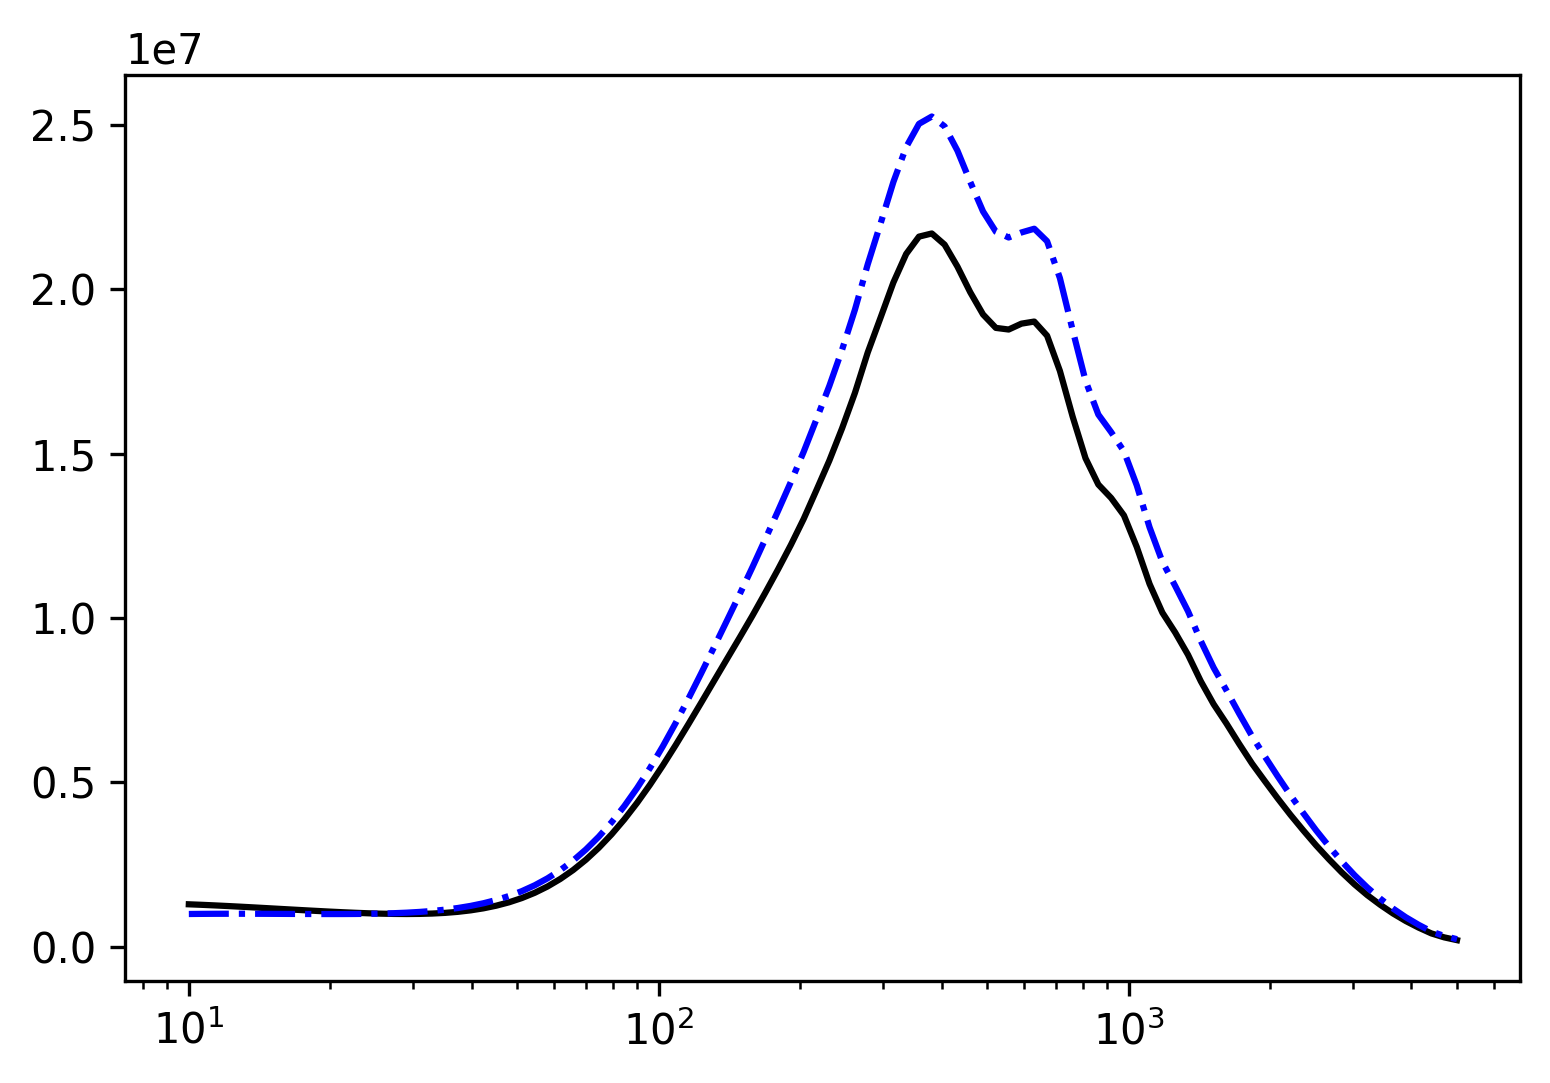

In [9]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1_denser  / (ClKK + f_N0(ells)), 'k')
plt.plot(ells, ells**2 * res1 / (ClKK + f_N0(ells)), 'b-.')
plt.legend(frameon=False)
plt.xscale('log')

In [10]:
mpm_chis = mpm.linspace(np.min(chis_restricted), np.max(chis_restricted), len(chis_restricted))

In [11]:
mpm_dchi = mpm_chis[1] - mpm_chis[0]

In [12]:
results = f_eHIeHI(chimin = chimin, 
                   chimax = chimax, 
                   dchi = mpm_dchi, 
                   chis = mpm_chis, 
                   Lambda = Lambda)

import pickle
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
with open(oup_fname, 'wb') as f:
    print(oup_fname)
    pickle.dump(results, f)

Computing matrix elements: 100%|██████████| 1365378/1365378 [03:37<00:00, 6283.03it/s]


/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_3.50000_zmax_8.10000_Lambda_3.55648e-03_chi_sample_2e13


In [13]:
mpm_eIeI = np.zeros_like(eHIeHI, dtype = np.complex128)
mpm_eLOeLO = np.zeros_like(eHIeHI, dtype = np.complex128)
mpm_cross = np.zeros_like(eHIeHI, dtype = np.complex128)

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eIeI[i,j] = _eIeI
    mpm_eLOeLO[i,j] = mpm_eLOeLO[j,i] = _eLOeLO
    mpm_cross[i,j] = mpm_cross[j,i] = _cross

100%|██████████| 1365378/1365378 [00:12<00:00, 112770.15it/s]


In [14]:
mpm_eHIeHI = mpm_eIeI + mpm_eLOeLO - mpm_cross
mpm_eHIeHI = np.real(mpm_eHIeHI)

In [15]:
D = np.diag(chis_restricted)
d = D @ IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ mpm_eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res2 = np.einsum('ij, ji->i', d.T, x)

# D = np.diag(chis_restricted)
# d = D @ IHi_kappa_windowed.T
# x = np.linalg.solve(D @ mpm_eHIeHI @ D, d)
# res2 = np.einsum('ij, ji->i', d.T, x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


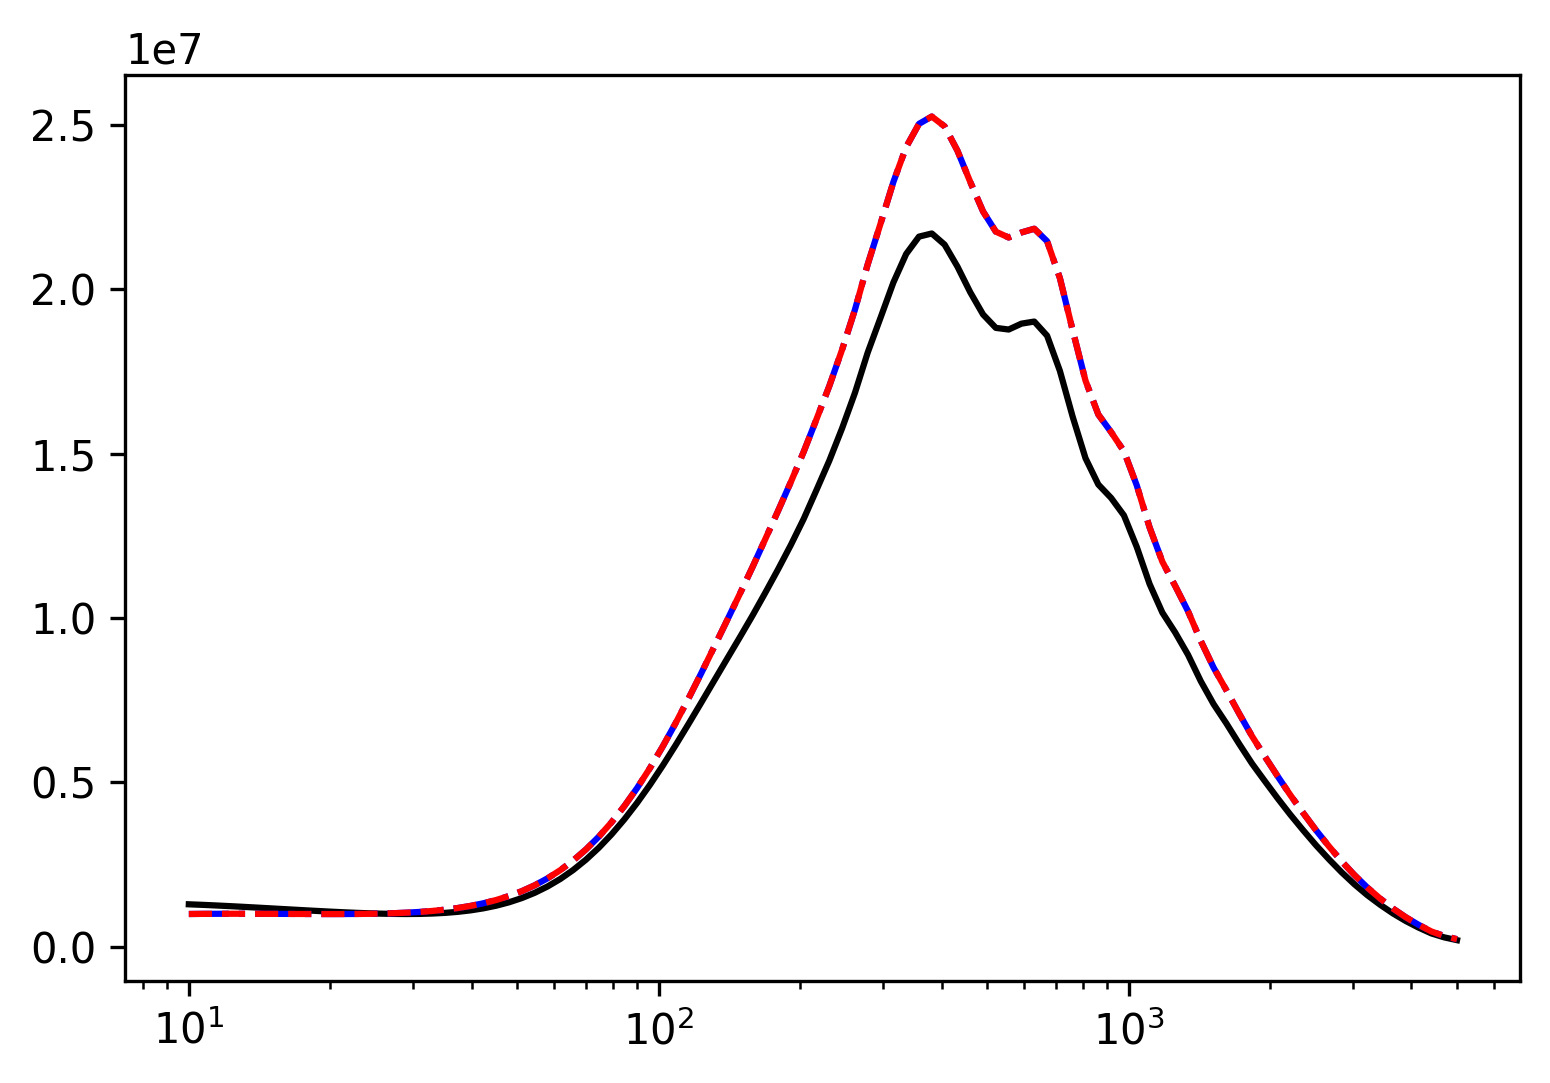

In [16]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1_denser  / (ClKK + f_N0(ells)), 'k')
plt.plot(ells, ells**2 * res1 / (ClKK + f_N0(ells)), 'b-.')

plt.plot(ells, ells**2 * res2 / (ClKK + f_N0(ells)), 'r--')

plt.legend(frameon=False)
plt.xscale('log')

In [17]:
mpm_chis_dense = mpm.linspace(np.min(chis_restricted), 
                              np.max(chis_restricted), 
                              2 * len(chis_restricted))
mpm_dchi = mpm_chis_dense[1] - mpm_chis_dense[0]

results = f_eHIeHI(chimin = chimin, 
                   chimax = chimax, 
                   dchi = mpm_dchi, 
                   chis = mpm_chis_dense, 
                   Lambda = Lambda)

Computing matrix elements: 100%|██████████| 5459860/5459860 [14:33<00:00, 6251.37it/s]  


In [18]:
mpm_eIeI = np.zeros((2 * len(chis_restricted), 
                     2 * len(chis_restricted)), 
                    dtype = np.complex128)
mpm_eLOeLO = np.zeros_like(mpm_eIeI, dtype = np.complex128)
mpm_cross = np.zeros_like(mpm_eIeI, dtype = np.complex128)

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eIeI[i,j] = _eIeI
    mpm_eLOeLO[i,j] = mpm_eLOeLO[j,i] = _eLOeLO
    mpm_cross[i,j] = mpm_cross[j,i] = _cross

100%|██████████| 5459860/5459860 [00:48<00:00, 111780.34it/s]


In [19]:
mpm_eHIeHI_dense = mpm_eIeI + mpm_eLOeLO - mpm_cross
mpm_eHIeHI_dense = np.real(mpm_eHIeHI_dense)

In [20]:
chis_dense = np.linspace(np.min(chis_restricted), 
                         np.max(chis_restricted), 
                         2 * len(chis_restricted))

D = np.diag(chis_dense)
d_dense = f_d(chis_dense)
L = np.linalg.cholesky(D @ mpm_eHIeHI_dense @ D)
y = np.linalg.solve(L, d_dense)
x = np.linalg.solve(L.T, y)
res3 = np.einsum('ij, ji->i', d_dense.T, x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


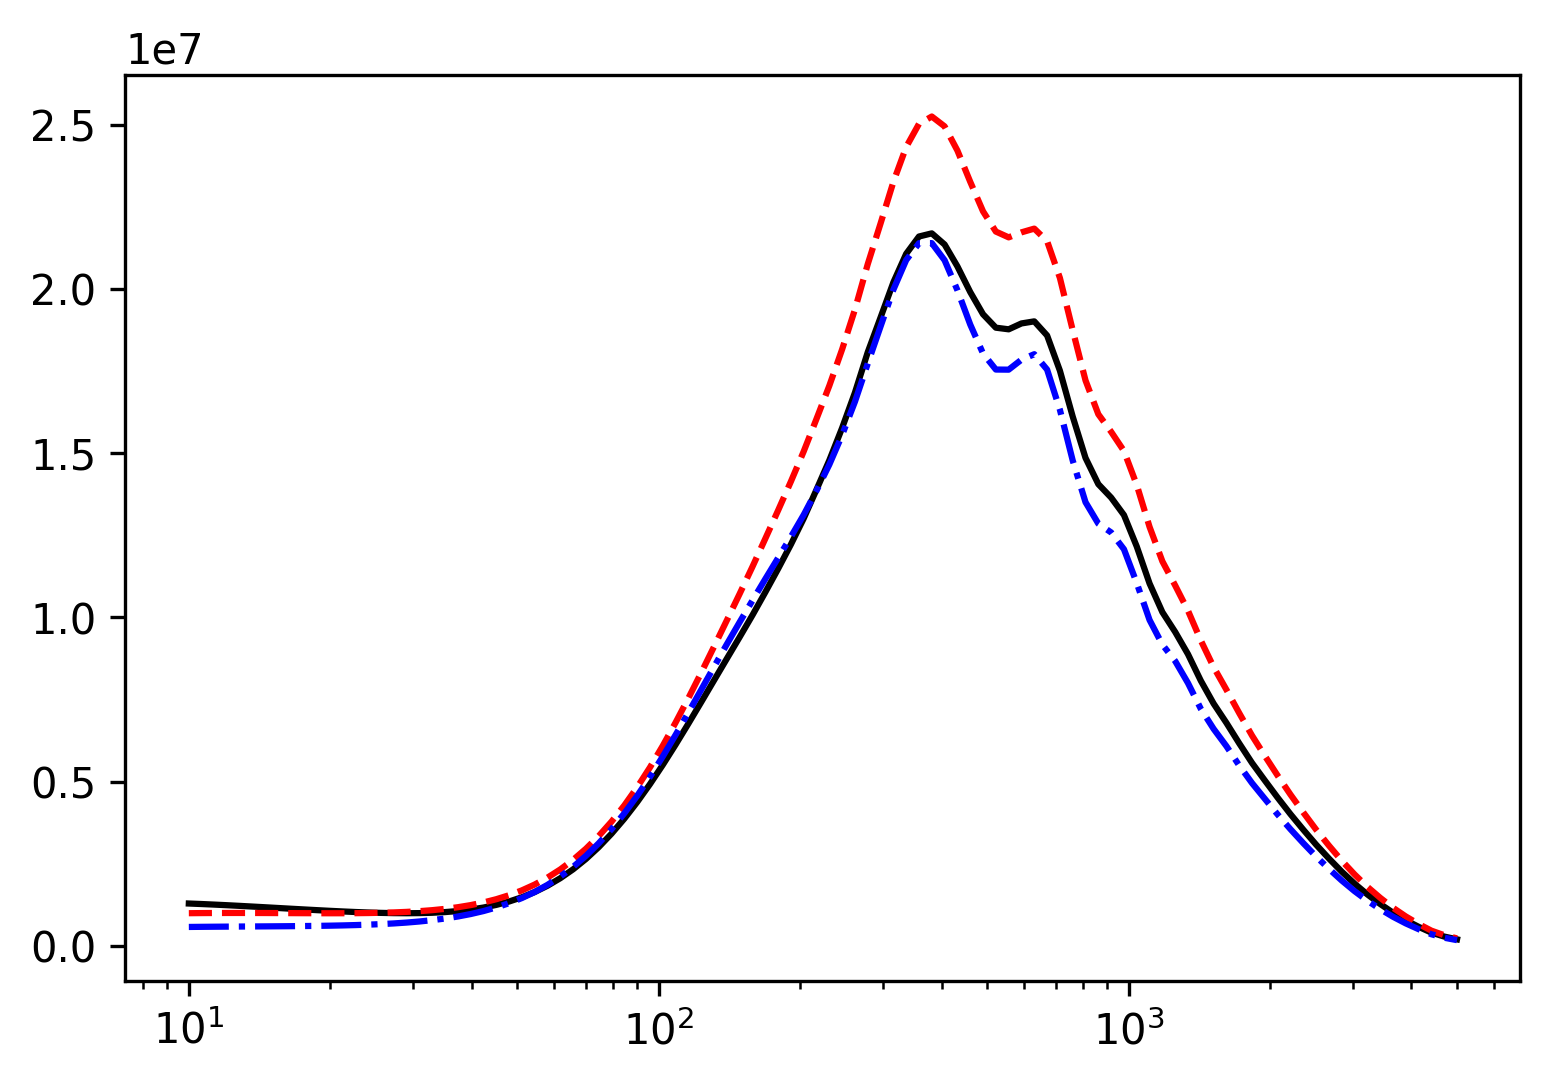

In [21]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1_denser / (ClKK + f_N0(ells)), 'k')
plt.plot(ells, ells**2 * res2 / (ClKK + f_N0(ells)), 'r--')
plt.plot(ells, ells**2 * res3 / (ClKK + f_N0(ells)), 'b-.')

plt.legend(frameon=False)
plt.xscale('log')